<a href="https://colab.research.google.com/github/Lingling-Lin/STAT-project/blob/master/Compare_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Simulation framework for model recovery with PCM**

We will do model recovery with PCM using the three fixed models from [Ejaz et al. (2015)](http://www.diedrichsenlab.org/pubs/Ejaz_NN_2015.pdf). *Hand usage predicts the structure of representations in sensorimotor cortex*, Nature Neuroscience.

The three fixed models are:


*   Null: G = np.eye, all finger patterns are equally far away from each other 
*   Muscle: Fixed model with G = covariance of muscle activities 
*   Natural: Fixed model with G = covariance of natural movement

where Muscle and Natural models are two competing models in our case; for convenience, we denote these three models by $G_0, G_1,G_2$, respectively.

Specifically, our goal in this section is to use simulated data sets to evaluate how well PCM adjudicated between these two competing models in a situation where the ground-truth (i.e. either muscle model or natural/usage model) is known.




In [2]:
!pip install PcmPy

  Created wheel for PcmPy: filename=PcmPy-0.9.1-py3-none-any.whl size=24553 sha256=377af89cd718e43dbb4e7886ec00a7462b8a6649c1f71e3685d59b2bce582086
  Stored in directory: /root/.cache/pip/wheels/6b/f9/ee/201a7cb712e6b8ecc96c8584cb618ff1e2bbf0d24d5e9d4ad7
Successfully built PcmPy


In [3]:
# Import necessary libraries
import PcmPy as pcm
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import itertools

Read in the activity Data (`Data`), condition vector (`cond_vec`), partition vector (`part_vec`), and model matrices for Muscle and Natural stats Models (`M`):

In [4]:
f = open('/content/drive/MyDrive/PcmPy/docs/demos/data_demo_finger7T.p','rb')
Data,cond_vec,part_vec,modelM = pickle.load(f)
f.close()

## Build models

Now we are building a list of models, using a list of second moment matrices

In [5]:
# Make an empty list
M = []
# Null model: All fingers are represented independently.
# For RSA model that would mean that all distances are equivalent
M.append(pcm.FixedModel('null',np.eye(5)))
# Muscle model: Structure is given by covariance structure of EMG signals
M.append(pcm.FixedModel('muscle',modelM[0]))
# Usage model: Structure is given by covariance structure of EMG signals
M.append(pcm.FixedModel('usage',modelM[1]))

## Data simulation and Model fitting

To simulate a data set, we need to make a design. In our case, it is 5 conditions (each finger is a condition) and 8 runs. 

In [6]:
# Make a design in this case it's 8 runs, 5 conditions
cond, part = pcm.make_design(5,8)

We then generate 500 data set (`Y`) either from muscle model or usage model (ground truth) with fixed parameter value 0.5, fixed noise variance 1, and alterable signal variance(s). We use 500 data sets because it will obtain a smoother curve in the plot than 100 data sets. 

Now we can fit the models to the data set in one go. The data frame `T_in` has the log-likelihood for each model (i.e. the log-likelihood for $G_0, G_1$ and $G_2$). In this example, we use the log-likelihood as PCM criteria. That is, to evaluate how well PCM selected between the two competing models, we compare the log-likelihood obtained from the fit of the true model (i.e. the model that generated that perticular data set) with that obtained from alternative competing model by counting the number of instances, in which PCM decided in favor of the correct model. The proportion of correct decision `PropC` ($\times 100\%$) over two competing models and simulation is used to measure the model-selection accuracy. 



In [12]:
mus = list()# The log-likelihood(logL) values for muscle model
usa = list() # The logL values for usage model
C = list() #boolean list; true if mus >= usa otherwise false
# For the first 500 sim(s) (G1 is true model) if mus >= usa, convert boolean 
# true be 1 false be 0. Vice versa for the second 500 sims.
correct = list() # a list contained either 0 or 1
propC = list() # proportion of correct decision
def GDP(s):
  C.clear()
  mus.clear()
  usa.clear()
  correct.clear()
  #for the first loop G1 is true model; for the second loop G2 is true model
  for i in range(1,3):
    # M[1] - muscle model (G1); M[2] - usage model(G2)
    # Y is generated by true model
    Y = pcm.sim.make_dataset(M[i], 0.5, cond, part_vec = part, n_sim = 500, signal = s, noise = 1)
    # Fits Models to a data set inidividually.
    T_in, theta_in = pcm.fit_model_individ(Y, M, fit_scale = True, verbose = False) 
    # use logL as PCM criteria
    L = T_in.likelihood.to_numpy()
    mus.append(L[:,1])
    usa.append(L[:,2])
  for i in range(0,len(mus)):
    C.append(mus[i] >= usa[i])
  correct.append([1 if (C[0])[v] == True else 0 for v in range(0, len(C[0]))])
  correct.append([1 if (C[1])[v] == False else 0 for v in range(0, len(C[1]))])
  propC.append(statistics.mean(correct[0] + correct[1])) # use + to flatten two lists


We call the function `GDP` with increasing signal variances `sig` from 0 to 1 with step = 0.1

In [13]:
sig = np.arange(0.0, 1.1, 0.1)
for i in sig:
  GDP(i)

In [14]:
propC

[0.504, 0.55, 0.587, 0.649, 0.695, 0.703, 0.751, 0.765, 0.768, 0.78, 0.783]

## Model selection accuracy for PCM

The model selection accuracy for PCM is shown below. As we can see, when signal strenth = 0, the proportion of correct decision (`PropC`) is near 0.5; `propC` is near 0.8 when signal = 1. When signal variance is large such as 100, `propC` will near 1. 

Text(0, 0.5, 'proportion of correct (100%)')

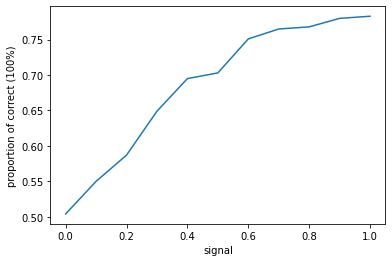

In [15]:
plt.plot(sig, propC)
# naming the x axis
plt.xlabel('signal')
# naming the y axis
plt.ylabel('proportion of correct (100%)')